In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

读取

In [2]:
def load_tweets_data(name): 
    csv_path = os.path.join("./twitter_cleaned/", name) 
    return pd.read_csv(csv_path)

tweets = load_tweets_data("test_posts.csv")

去除无关列，只留event timestamp label，更新event列信息

In [3]:
tweets.drop(["post_text"],axis=1,inplace=True)
tweets.drop(["post_id"],axis=1,inplace=True)
tweets.drop(["user_id"],axis=1,inplace=True)
tweets.drop(["username"],axis=1,inplace=True)

# 修改更新event列
split_result = tweets['image_id'].str.split('_',expand=True)
tweets.insert(0, 'event', split_result[0])
tweets.drop(["image_id"],axis=1,inplace=True)

取出timestamp，处理格式

In [4]:
# 分别取出年月日
split_time = tweets['timestamp'].str.split(' ',expand=True)
split_time = split_time.iloc[:,[5,1,2]]

# 将月的格式进行转换
dict_month = {'Jan':'1','Feb':'2','Mar':'3','Apr':'4','May':'5','Jun':'6',
              'Jul':'7','Aug':'8','Sep':'9','Oct':'10','Nov':'11','Dec':'12'}
data = []
for index, value in split_time[1].items():
    data.append(dict_month.get(value))

# 插入转换后的列，删除原列，更改列索引名
split_time.insert(1, 'time', data)
split_time.drop([1],axis=1,inplace=True)
split_time.columns=['year','month','day']

# 合并成一列
split_time["time_month"] = split_time["year"] +'.'+ split_time["month"]+'.'+ split_time["day"]

# 删除子列，只留合并后的列
split_time.drop(["year"],axis=1,inplace=True)
split_time.drop(["month"],axis=1,inplace=True)
split_time.drop(["day"],axis=1,inplace=True)

# 插入格式正确的时间列
norm_data = pd.concat([tweets,split_time], axis=1)
norm_data.drop(["timestamp"],axis=1,inplace=True)
norm_data.head()

,event,label,time_month
0,attacks,fake,2015.11.14
1,attacks,fake,2015.11.14
2,attacks,fake,2015.11.14
3,attacks,fake,2015.11.14
4,attacks,fake,2015.11.14


norm_data为最终格式，查看数据集整体情况

In [5]:
event = norm_data.event.unique()
print(event,len(event))
norm_data['event'].value_counts()

['attacks' 'black' 'bowie' 'brussels' 'burst' 'bush' 'five' 'fuji'
 'gandhi' 'halfEverything' 'hubble' 'immigrants' 'john' 'mc' 'nazi'
 'north' 'not' 'pakistan' 'protest' 'refugees' 'rio' 'soldier' 'syrian'
 'ukrainian' 'woman'] 25


attacks           288
fuji              170
bowie              72
refugees           68
not                67
protest            64
pakistan           53
immigrants         51
halfEverything     39
rio                33
gandhi             29
bush               27
burst              25
john               20
hubble             18
syrian             12
woman              11
north              10
brussels            9
black               7
mc                  6
five                6
nazi                4
soldier             1
ukrainian           1
Name: event, dtype: int64

取出某一事件，时序变化特征

In [12]:
# 取出特定时间的推文和时间戳
one_event = norm_data.loc[norm_data['event'] == 'bowie']
time = one_event.time_month.unique()

# 插入时间为key
dict_event = {}
dict_event = {}.fromkeys([ti for ti in time])

# 插入真假类别为子key 
class_event = ['real', 'fake']
for key in dict_event.keys():
    dict_event[key] = {}.fromkeys([key for key in class_event])

# 向字典框架填入数量
for index, row in one_event.iterrows():
    if dict_event[row['time_month']][row['label']] == None:
        dict_event[row['time_month']][row['label']] = 1
    else:
        dict_event[row['time_month']][row['label']] += 1

# 按日期排序
dict_event = dict(sorted(dict_event.items(), key=lambda x: x[0]))

# 转为dataframe并反转
df_event = pd.DataFrame(dict_event).T
df_event

,real,fake
2015.1.13,NaN,1.0
2015.11.20,1.0,NaN
2015.3.09,NaN,1.0
2015.9.12,NaN,1.0
2016.1.11,27.0,4.0
2016.1.12,11.0,15.0
2016.1.13,4.0,NaN
2016.1.14,3.0,1.0
2016.1.15,NaN,1.0
2016.1.21,1.0,NaN


可视化

<AxesSubplot:>

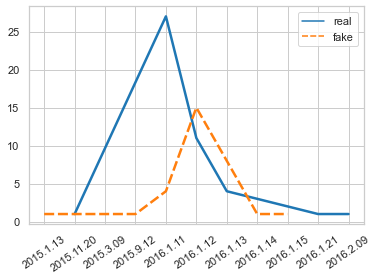

In [13]:
sns.set_theme(style="whitegrid")
plt.xticks(rotation=35) 
sns.lineplot(data=df_event, palette="tab10", linewidth=2.5)